    This file is a part of the lor_neuro_rat project.
    Copyright (C) 2019 anonimous

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

    Please contact with me by E-mail: shkolnick.kun@gmail.com
    
    This file is based on 
    <https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model>
    which has been released under the Apache 2.0 open source license by Larry Freeman <https://www.kaggle.com/larryfreeman>

In [1]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import h5py

import matplotlib.pyplot as plt
np.random.seed(32)

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import gc
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Embedding, Flatten
from keras.layers import Add, Concatenate
from keras.layers import Dropout, SpatialDropout1D, BatchNormalization
from keras.layers import GRU, LSTM, Bidirectional, SeparableConv1D, Dense
from keras.layers import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.callbacks import Callback
from keras import optimizers
from keras.layers import Lambda

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords

import os
#os.environ['OMP_NUM_THREADS'] = '4'

#from unidecode import unidecode

import time
%matplotlib inline


from tensorflow import ConfigProto
from tensorflow import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
session = Session(config=config)

Using TensorFlow backend.


# Сформируем датасет

In [2]:
df = pd.read_pickle('data/XyWrdTok1с.pkl')

                         TopId             MsgId                      Creator  \
0        /forum/talks/12648516  comment-12649855      /people/mandala/profile   
1        /forum/talks/10056125  comment-10056157        /people/dvrts/profile   
2        /forum/talks/11903900  comment-11904141   /people/kiverattes/profile   
3        /forum/talks/12103367  comment-12103408   /people/alexferman/profile   
4  /forum/development/10968185  comment-10968212  /people/Progressive/profile   

                            Time                             SrcLink  \
0  2016-06-07T20:01:40.393+03:00  /forum/talks/12648516?cid=12649823   
1  2014-01-15T14:47:38.711+04:00                                       
2  2015-08-29T22:59:17.271+03:00  /forum/talks/11903900?cid=11904067   
3  2015-11-12T08:57:55.115+03:00  /forum/talks/12103367?cid=12103402   
4  2014-10-24T20:08:29.646+04:00                                       

                                           DelReason  \
0  Сообщение удалено по 

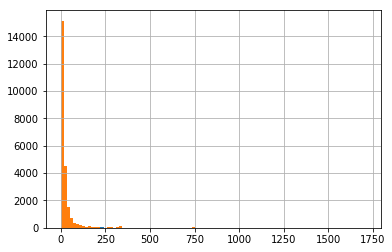

In [3]:
print(df.head())
print(df.describe())
df['TokCnt'].hist(bins=100)
df['WrdCnt'].hist(bins=100)

# Подготовка имбеддингов

In [4]:
y = df['Use'].values
X = [' '.join(tokens) for tokens in list(df['Tokens'])]

In [5]:
print(X[0])
print(X[1000])
print(y[0])
print(y[15000])

уровень развитие цивилизация лишь мы смотреть потомок крутить палец висок иметь значение этот ерунда вопрос страшно жить восклицание
мартышка зарабатывать корма тестирование мочь высказывать мнение
1
0


In [6]:
#Приделываем токенайзер из keras
max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
print(len(tokenizer.word_index))

45748


In [7]:
wrds = []
idxs = []
for w, i in tokenizer.word_index.items():
    wrds.append(w)
    idxs.append(i)
    
if 'рашка' in wrds:
    print(idxs[wrds.index('рашка')])

1743


In [8]:
#Сохраняем токенайзер
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
#Грузим токенайзер
with open('models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [10]:
max_len = 150
X_seq = tokenizer.texts_to_sequences(X)
X_seq_pad = pad_sequences(X_seq, maxlen=max_len)

In [11]:
h5f = h5py.File('data/Xy.h5', 'w')
print(h5f.create_dataset('X_seq_pad', data=X_seq_pad))
print(h5f.create_dataset('y', data=y))
h5f.close()

<HDF5 dataset "X_seq_pad": shape (23556, 150), type "<i4">
<HDF5 dataset "y": shape (23556,), type "<i8">


In [12]:
h5f = h5py.File('data/Xy.h5', 'r')
X_seq_pad = h5f['X_seq_pad'][:]
y         = h5f['y'][:]
h5f.close()
print(X_seq_pad.shape)
print(y.shape)

(23556, 150)
(23556,)


In [13]:
#Вычисляем матрицу весов слоя имбеддингов
from pymagnitude import *
import gensim

mg = Magnitude('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.magnitude')
ft = gensim.models.fasttext.FastText.load('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model')

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.zeros((nb_words,300))

for word, i in word_index.items():
    #
    if i >= max_features: 
        continue
    #
    #embedding_matrix[i] = mg.query(word)
    try:
        embedding_matrix[i] = ft.wv[word]
    except:
        embedding_matrix[i] = mg.query(word)
    

In [14]:
#Сохраняем матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtx.h5', 'w')
print(h5f.create_dataset('EmbeddingMtx', data=embedding_matrix))
h5f.close()

<HDF5 dataset "EmbeddingMtx": shape (20000, 300), type "<f8">


In [15]:
#Грузим матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtx.h5', 'r')
embedding_matrix = h5f['EmbeddingMtx'][:]
h5f.close()

In [16]:
print(mg.most_similar(embedding_matrix[41]))

[('писать', 2.7740248044537354), ('написать', 2.3093317386643784), ('писаться', 1.9480354263493773), ('аписать', 1.924823287961308), ('пописывать', 1.9049477046842551), ('написаный', 1.8314904320010685), ('сочинять', 1.8245514440178163), ('читывать', 1.8131628951666887), ('строчить', 1.8044062893396267), ('цитировать', 1.7813154529572686)]


In [17]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, cv_iter=0, arch=0):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val, self.Weigths = validation_data
        self.max_score = 0
        self.not_better_count = 0
        self._cv_iter = cv_iter
        self._arch = arch

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1, batch_size=512)
            score = roc_auc_score(self.y_val, y_pred, sample_weight=self.Weigths)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
                model.save("models/best_model_%d_%d.h5"%(int(self._arch),int(self._cv_iter)))
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 5:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

In [ ]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 0
def get_model(clipvalue=1.,num_filters=64,dropout=0.1,embed_size=300):
    inp = Input(shape=(None, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout)(x)
    
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True, activation='elu'))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([avg_pool, x_h, x_c, max_pool])
    
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue,lr=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [ ]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 1
nn_arch = 1
def get_model(clipvalue=1.,num_filters=64,dropout=0.1,embed_size=300):
    inp = Input(shape=(None, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout)(x)
    
    # Тут мы получаем конкатенацию LSTM по двум направлениям 
    # плюс Hidden state и Cell state по двум направлениям
    x, x_a, x_b, x_c, x_d = Bidirectional(LSTM(num_filters, return_sequences=True, return_state = True))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([avg_pool, x_a, x_b, x_c, x_d, max_pool])
    
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [ ]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 2
nn_arch = 2
def get_model(clipvalue=1.,num_filters=64, dropout=0.2,embed_size=300):
    inp = Input(shape=(None, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout)(x)
    x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)

    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout)(x)
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True, activation='elu'))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([avg_pool, x_h, x_c, max_pool])
    
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [ ]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 3
def get_model(clipvalue=1.,num_filters=128,dropout=0.1,embed_size=300):
    inp = Input(shape=(None, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout)(x)
    
    x_2 = SeparableConv1D(embed_size, 2, activation='elu', padding='same')(x)
    x_3 = SeparableConv1D(embed_size, 3, activation='elu', padding='same')(x)
    x = Add()([x, x_2, x_3])
    
    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout)(x)
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True, activation='elu'))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([avg_pool, max_pool, x_h, x_c])
    
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue,lr=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [39]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 4
def get_model(clipvalue=1.,num_filters=128,dropout=0.2,embed_size=300):
    inp = Input(shape=(None, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout)(x)
    x_2 = SeparableConv1D(embed_size, 2, activation='elu', padding='same')(x)
    #x_3 = SeparableConv1D(embed_size, 3, activation='elu', padding='same')(x)
    x = Concatenate()([x, x_2])
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([avg_pool, max_pool])
    
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue,lr=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [37]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 5
def get_model(clipvalue=1.,num_filters=128,dropout=0.5,embed_size=300):
    inp = Input(shape=(None, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout)(x)
    x_2 = SeparableConv1D(embed_size, 2, activation='elu', padding='same')(x)
    
    x_b = GRU(embed_size, return_sequences=True, activation='elu')(x)
    x = Add()([x, x_b])
    
    x_2 = BatchNormalization()(x_2)
    x_2 = SpatialDropout1D(dropout)(x_2)
    x_2b = GRU(embed_size, return_sequences=True, activation='elu')(x_2)
    x_2 = Add()([x_2, x_2b])
    #x_3 = SeparableConv1D(embed_size, 3, activation='elu', padding='same')(x)
    x = Concatenate()([x, x_2])
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([avg_pool, max_pool])
    
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue,lr=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [40]:
print('Model:' , nn_arch)
#model = get_model()

batch_size = 512

# Used epochs=100 with early exiting for best score.
epochs = 100
gc.collect()
K.clear_session()

# Change to 4
num_folds = 5 #number of folds

#Приводим типы
y = np.array(y)

#Веса примеров, "меняем местами" 1 и 0
w_0 = 1/np.sum((y == 0.0).astype('float'))
w_1 = 1.0/np.sum((y == 1.0).astype('float'))
w = w_0*(y == 0.0).astype('float') + w_1*(y == 1.0).astype('float')
w /= np.sum(w)
w *= len(y)

kf = KFold(n_splits=num_folds, shuffle=True)

i = 0
for train_index, test_index in kf.split(X):
    
    gc.collect()
    K.clear_session()
    
    y_train = y[train_index] 
    y_test  = y[test_index]
    
    X_train = X_seq_pad[train_index]
    X_test  = X_seq_pad[test_index]
    
    w_train = w[train_index]
    w_test  = w[test_index]
    
    model = get_model()
    
    ra_val = RocAucEvaluation(validation_data=(X_test, y_test, w_test), interval = 1, cv_iter=i, arch=nn_arch)
    
    model.fit(X_train, y_train, sample_weight=w_train, batch_size=batch_size, epochs=epochs, verbose=1,
             callbacks = [ra_val])
    
    y_t = load_model("models/best_model_%d_%d.h5"%(int(nn_arch),int(i))).predict(X_test, verbose=1, batch_size=512)
    y_a = (y_t>0.5).astype('float').reshape(y_test.shape)
    
    print('Weighted scores')
    print(' *    Acc:', accuracy_score(y_test, y_a, sample_weight=w_test))
    print(' *   Prec:', precision_score(y_test, y_a, sample_weight=w_test))
    print(' * Recall:', recall_score(y_test, y_a, sample_weight=w_test))
    print(' *     F1:', f1_score(y_test, y_a, sample_weight=w_test))
    print(' * RocAuc:', roc_auc_score(y_test, y_t, sample_weight=w_test))

    print('Scores')
    print(' *    Acc:', accuracy_score(y_test, y_a))
    print(' *   Prec:', precision_score(y_test, y_a))
    print(' * Recall:', recall_score(y_test, y_a))
    print(' *     F1:', f1_score(y_test, y_a))
    print(' * RocAuc:', roc_auc_score(y_test, y_t))

    print('================')
    print('FP:', np.sum((y_a != y_test).astype('float')*y_a))
    print('FN:', np.sum((y_a != y_test).astype('float')*y_test))
    print('TP:', np.sum((y_a == y_test).astype('float')*y_a))
    print('TN:', np.sum((y_a == y_test).astype('float')*(1-y_test)))
    
    gc.collect()
    
    i += 1

print("Done")

Model: 4
Epoch 1/100
4712/4712 [==============================] - 0s 48us/step

 ROC-AUC - epoch: 1 - score: 0.833046 

*** New High Score (previous: 0.000000) 

Epoch 2/100
4712/4712 [==============================] - 0s 32us/step

 ROC-AUC - epoch: 2 - score: 0.853218 

*** New High Score (previous: 0.833046) 

Epoch 3/100
4712/4712 [==============================] - 0s 32us/step

 ROC-AUC - epoch: 3 - score: 0.864459 

*** New High Score (previous: 0.853218) 

Epoch 4/100
4712/4712 [==============================] - 0s 32us/step

 ROC-AUC - epoch: 4 - score: 0.864333 

Epoch 5/100
4712/4712 [==============================] - 0s 33us/step

 ROC-AUC - epoch: 5 - score: 0.875692 

*** New High Score (previous: 0.864459) 

Epoch 6/100
4712/4712 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 6 - score: 0.878338 

*** New High Score (previous: 0.875692) 

Epoch 7/100
4712/4712 [==============================] - 0s 31us/step

 ROC-AUC - epoch: 7 - score: 0.883603 

*** 

Epoch 4/100
4711/4711 [==============================] - 0s 31us/step

 ROC-AUC - epoch: 4 - score: 0.872766 

*** New High Score (previous: 0.867419) 

Epoch 5/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 5 - score: 0.876532 

*** New High Score (previous: 0.872766) 

Epoch 6/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 6 - score: 0.877145 

*** New High Score (previous: 0.876532) 

Epoch 7/100
4711/4711 [==============================] - 0s 33us/step

 ROC-AUC - epoch: 7 - score: 0.882508 

*** New High Score (previous: 0.877145) 

Epoch 8/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 8 - score: 0.885633 

*** New High Score (previous: 0.882508) 

Epoch 9/100
4711/4711 [==============================] - 0s 34us/step

 ROC-AUC - epoch: 9 - score: 0.881311 

Epoch 10/100
4711/4711 [==============================] - 0s 31us/step

 ROC-AUC - epoch: 10 - score: 0.886230 

*** New Hig

Epoch 9/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 9 - score: 0.885217 

*** New High Score (previous: 0.882892) 

Epoch 10/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 10 - score: 0.885221 

*** New High Score (previous: 0.885217) 

Epoch 11/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 11 - score: 0.887613 

*** New High Score (previous: 0.885221) 

Epoch 12/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 12 - score: 0.888112 

*** New High Score (previous: 0.887613) 

Epoch 13/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 13 - score: 0.885316 

Epoch 14/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 14 - score: 0.886848 

Epoch 15/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 15 - score: 0.890482 

*** New High Score (previous: 0.888112) 

E

Epoch 1/100
4711/4711 [==============================] - 0s 45us/step

 ROC-AUC - epoch: 1 - score: 0.823631 

*** New High Score (previous: 0.000000) 

Epoch 2/100
4711/4711 [==============================] - 0s 31us/step

 ROC-AUC - epoch: 2 - score: 0.847108 

*** New High Score (previous: 0.823631) 

Epoch 3/100
4711/4711 [==============================] - 0s 30us/step

 ROC-AUC - epoch: 3 - score: 0.856129 

*** New High Score (previous: 0.847108) 

Epoch 4/100
4711/4711 [==============================] - 0s 32us/step

 ROC-AUC - epoch: 4 - score: 0.865919 

*** New High Score (previous: 0.856129) 

Epoch 5/100
4711/4711 [==============================] - 0s 31us/step

 ROC-AUC - epoch: 5 - score: 0.868144 

*** New High Score (previous: 0.865919) 

Epoch 6/100
4711/4711 [==============================] - 0s 31us/step

 ROC-AUC - epoch: 6 - score: 0.872464 

*** New High Score (previous: 0.868144) 

Epoch 7/100
4711/4711 [==============================] - 0s 31us/step

 ROC-AUC - 

# Типичные метрики на кросс-валидации
По разым значениям соотношения TP/TN в датасете

Самая удачная модель - 0

## 1/1

Weighted scores
 *    Acc: 0.8083041251011054
 *   Prec: 0.82168409466153
 * Recall: 0.7941489361702128
 *     F1: 0.8076819042466866
 * RocAuc: 0.8898640985074974

Scores
 *    Acc: 0.8083041251011054
 *   Prec: 0.82168409466153
 * Recall: 0.7941489361702128
 *     F1: 0.8076819042466866
 * RocAuc: 0.8898640985074974

## 1/2

Weighted scores
 *    Acc: 0.8088235294117647
 *   Prec: 0.8343594253884491
 * Recall: 0.7696051919956733
 *     F1: 0.8006752004501336
 * RocAuc: 0.8905964539186791

Scores
 *    Acc: 0.8218587093294984
 *   Prec: 0.71579476861167
 * Recall: 0.7696051919956733
 *     F1: 0.7417253062288245
 * RocAuc: 0.8905964539186791

## 1/5

Weighted scores
 *    Acc: 0.8105686695278971
 *   Prec: 0.8398097668483119
 * Recall: 0.7710330138445154
 *     F1: 0.8039531397478944
 * RocAuc: 0.891488846674163
 
Scores
 *    Acc: 0.8372573687994249
 *   Prec: 0.511841640155532
 * Recall: 0.7710330138445154
 *     F1: 0.615253877204164
 * RocAuc: 0.8914888466741502

## Все данные

In [ ]:
#y_all = load_model('models/best_model_0_0.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_0_1.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_0_2.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_0_3.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_0_4.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all /= 5.0#2.0*np.average(y_all)

In [ ]:
#y_t = (y_all>1.0*np.average(y_all)).astype('float').reshape(y.shape)
y_t = (y_all>0.8).astype('float').reshape(y.shape)

#print('==== Weghtted scores ====')
#print('   Acc:', accuracy_score(y, y_t, sample_weight=w))
#print('  Prec:', precision_score(y, y_t, sample_weight=w))
#print('Recall:', recall_score(y, y_t, sample_weight=w))
#print('    F1:', f1_score(y, y_t, sample_weight=w))
#print('RocAuc:', roc_auc_score(y, y_t, sample_weight=w))

print('==== Scores ====')
print('   Acc:', accuracy_score(y, y_t))
print('  Prec:', precision_score(y, y_t))
print('Recall:', recall_score(y, y_t))
print('    F1:', f1_score(y, y_t))
print('RocAuc:', roc_auc_score(y, y_all))

print('================')
print('FP:', np.sum((y_t != y).astype('float')*y_t))
print('FN:', np.sum((y_t != y).astype('float')*y))
print('TP:', np.sum((y_t == y).astype('float')*y_t))
print('TN:', np.sum((y_t == y).astype('float')*(1-y)))
print('N: ', len(X))

In [ ]:
df.describe()

In [ ]:
df['FN'] = y*(y_t != y).astype('float')
df['FP'] = y_t*(y_t != y).astype('float')

In [ ]:
df_fp = df[df['FP'] == 1.0]

In [ ]:
df_fp.describe()

In [ ]:
df_fp.to_pickle('data/Xy_fp.pkl')
df_fp.to_excel('data/Xy_fp.xlsx')

In [ ]:
df_fn = df[df['FN'] == 1.0]

In [ ]:
df_fn.to_pickle('data/Xy_fn.pkl')
df_fn.to_excel('data/Xy_fn.xlsx')